# Energieverbruik en -productie van Nederland

Energie is duur. Dat weet iedereen. Tijdens dit project gaan "de Potter Robin" & "Verhaegen Stijn" een analyse doen over het energieverbruik en de productie ervan in Nederland.

## Inhoud analyse

1. `Lijst inhoud analyse`

In [114]:
from pyspark.sql import SparkSession
from pyspark.sql import Row
from pyspark.rdd import RDD
import matplotlib.pyplot as plt
from pyspark.sql.types import *
from pyspark.sql.functions import *
import glob
import os

In [115]:
spark = SparkSession.builder.appName("EnergyConsumption").getOrCreate()
sc = spark.sparkContext

Path naar de data

In [116]:
path_gas = r"./data/Gas/"
path_electricity = r"./data/Electricity/"

Het schema dat we zullen gebruiken voor het dataframe van gas en elektriciteit. 

In [117]:
schema = StructType([
    StructField('net_manager', StringType(), True),
    StructField('purchase_area', StringType(), True),
    StructField('street', StringType(), True),
    StructField('zipcode_from', StringType(), True),
    StructField('zipcode_to', StringType(), True),
    StructField('city', StringType(), True),
    StructField('num_connections', DoubleType(), True),
    StructField('delivery_perc', DoubleType(), True),
    StructField('perc_of_active_connections', DoubleType(), True),
    StructField('type_conn_perc', DoubleType(), True),
    StructField('type_of_connection', StringType(), True),
    StructField('annual_consume', DoubleType(), True),
    StructField('year', IntegerType(), True)
  ])

Hier declareren we de make_df functie die de raw data zal omzetten naar een DataFrame. We verwijderen ook een aantal files omdat de data van '*coteq_gas*' hetzelfde is van 2013 - 2018. Ook hebben wij '*rendo_gas_2019*' verwijderd aangezien die null values bezit.

In [118]:
def make_df(path):
    rdd_full = sc.emptyRDD()
    df_full = spark.createDataFrame(rdd_full,schema)
    for filename in os.listdir(path):
        if(filename == "rendo_gas_2019.csv" or 
           filename == "coteq_gas_2014.csv" or 
           filename == "coteq_gas_2015.csv" or 
           filename == "coteq_gas_2016.csv" or 
           filename == "coteq_gas_2017.csv" or 
           filename == "coteq_gas_2018.csv"):
#            filename == "endurisgas_01012015.csv"
            print("removed " + filename)
        else:
            # Read file and assign data
            year = filename[-8:]
            year = year[0:4]
            data = spark.read.option("header","true").option("inferSchema", "true").csv(path + filename, sep=",")
            listColumns = data.columns
            if 'ï»¿NETBEHEERDER' in listColumns:
                data = data.withColumnRenamed("ï»¿NETBEHEERDER","net_manager")
            data = data.select(data.net_manager, data.purchase_area, data.street, data.zipcode_from,
                               data.zipcode_to,
                               data.city,
                               data.num_connections,
                               data.delivery_perc,
                               data.perc_of_active_connections,
                               data.type_conn_perc,
                               data.type_of_connection,
                               data.annual_consume)
            data = data.withColumn('year', lit(int(year)))
            df_full = df_full.union(data)
    return df_full

We gebruiken de functie make_df(path) die we juist gedefinieerd hebben om al de gasdata in te lezen. 

In [119]:
df_gas = make_df(path_gas)


removed coteq_gas_2018.csv
removed rendo_gas_2019.csv
removed coteq_gas_2015.csv
removed coteq_gas_2014.csv
removed coteq_gas_2016.csv
removed coteq_gas_2017.csv


In [120]:
df_gas.show(vertical=True)

-RECORD 0------------------------------------------
 net_manager                | 8717127750009        
 purchase_area              | GAS Gastransport ... 
 street                     | Poststraat           
 zipcode_from               | 4301AA               
 zipcode_to                 | 4301AA               
 city                       | ZIERIKZEE            
 num_connections            | 14.0                 
 delivery_perc              | 100.0                
 perc_of_active_connections | 100.0                
 type_conn_perc             | 50,00                
 type_of_connection         | G4                   
 annual_consume             | 3736.0               
 year                       | 2015                 
-RECORD 1------------------------------------------
 net_manager                | 8717127750009        
 purchase_area              | GAS Gastransport ... 
 street                     | Poststraat           
 zipcode_from               | 4301AB               
 zipcode_to 

In [121]:
df_gas.count()

3665480

In [122]:
df_gas.printSchema()

root
 |-- net_manager: string (nullable = true)
 |-- purchase_area: string (nullable = true)
 |-- street: string (nullable = true)
 |-- zipcode_from: string (nullable = true)
 |-- zipcode_to: string (nullable = true)
 |-- city: string (nullable = true)
 |-- num_connections: double (nullable = true)
 |-- delivery_perc: double (nullable = true)
 |-- perc_of_active_connections: double (nullable = true)
 |-- type_conn_perc: string (nullable = true)
 |-- type_of_connection: string (nullable = true)
 |-- annual_consume: double (nullable = true)
 |-- year: integer (nullable = true)



Hoewel we in het schema meegeven dat de kolom 'type_conn_perc' het datatype Double heeft, is dit nog niet het geval. Het datatype is String. We denken dat dit komt omdat de values komma's bevatten. Bv: 50,0 ipv 50.0. We veranderen dus alle komma's met punten voor deze kolom. Als we dit niet doen en we casten deze kolom meteen naar een double, dan worden de waardes die een komma bevatten omgezet naar null. 

In [123]:
df_gas = df_gas.withColumn('type_conn_perc', regexp_replace('type_conn_perc', '[,]', '.'))

In [124]:
df_gas.show(vertical=True)

-RECORD 0------------------------------------------
 net_manager                | 8717127750009        
 purchase_area              | GAS Gastransport ... 
 street                     | Poststraat           
 zipcode_from               | 4301AA               
 zipcode_to                 | 4301AA               
 city                       | ZIERIKZEE            
 num_connections            | 14.0                 
 delivery_perc              | 100.0                
 perc_of_active_connections | 100.0                
 type_conn_perc             | 50.00                
 type_of_connection         | G4                   
 annual_consume             | 3736.0               
 year                       | 2015                 
-RECORD 1------------------------------------------
 net_manager                | 8717127750009        
 purchase_area              | GAS Gastransport ... 
 street                     | Poststraat           
 zipcode_from               | 4301AB               
 zipcode_to 

Nu we dit gedaan hebben moeten we deze kolom nog casten naar het datatype Double. 

In [125]:
df_gas = df_gas.withColumn('type_conn_perc', df_gas['type_conn_perc'].cast(DoubleType()))

In [126]:
df_gas.printSchema()

root
 |-- net_manager: string (nullable = true)
 |-- purchase_area: string (nullable = true)
 |-- street: string (nullable = true)
 |-- zipcode_from: string (nullable = true)
 |-- zipcode_to: string (nullable = true)
 |-- city: string (nullable = true)
 |-- num_connections: double (nullable = true)
 |-- delivery_perc: double (nullable = true)
 |-- perc_of_active_connections: double (nullable = true)
 |-- type_conn_perc: double (nullable = true)
 |-- type_of_connection: string (nullable = true)
 |-- annual_consume: double (nullable = true)
 |-- year: integer (nullable = true)



Het schema van het dataframe df_gas is nu in orde. Elke kolom heeft het juiste datatype. 

We doorlopen nu hetzelfde proces voor de elektriciteitsdata. We gebruiken de functie make_df(path) om al de elektriciteitsdata in te lezen.

In [127]:
df_electricity = make_df(path_electricity)

In [128]:
df_electricity.show(vertical=True)

-RECORD 0-----------------------------------------
 net_manager                | 8716874000009       
 purchase_area              | Stedin Utrecht      
 street                     | Egelshoek           
 zipcode_from               | 1213RC              
 zipcode_to                 | 1231AB              
 city                       | HILVERSUM           
 num_connections            | 30.0                
 delivery_perc              | 90.0                
 perc_of_active_connections | 100.0               
 type_conn_perc             | 80.0                
 type_of_connection         | 3x25                
 annual_consume             | 5909.0              
 year                       | 2019                
-RECORD 1-----------------------------------------
 net_manager                | 8716874000009       
 purchase_area              | Stedin Utrecht      
 street                     | Rembrandtlaan       
 zipcode_from               | 1231AC              
 zipcode_to                 | 1

In [129]:
df_electricity.count()

4077352

In [130]:
df_electricity.printSchema()

root
 |-- net_manager: string (nullable = true)
 |-- purchase_area: string (nullable = true)
 |-- street: string (nullable = true)
 |-- zipcode_from: string (nullable = true)
 |-- zipcode_to: string (nullable = true)
 |-- city: string (nullable = true)
 |-- num_connections: double (nullable = true)
 |-- delivery_perc: string (nullable = true)
 |-- perc_of_active_connections: string (nullable = true)
 |-- type_conn_perc: string (nullable = true)
 |-- type_of_connection: string (nullable = true)
 |-- annual_consume: double (nullable = true)
 |-- year: integer (nullable = true)



Ook bij het dataframe df_electricity is het schema nog niet correct toegepast. Niet alle kolommen hebben het juiste datatype. Ook hier casten we de kolommen 'delivery_perc', 'perc_of_active_connections' en 'type_conn_perc' naar het datatype dat we in het schema hebben vastgelegd, namelijk een Double. 

In [131]:
df_electricity = df_electricity.withColumn('delivery_perc', df_electricity['delivery_perc'].cast(DoubleType()))
df_electricity = df_electricity.withColumn('perc_of_active_connections', df_electricity['perc_of_active_connections'].cast(DoubleType()))
df_electricity = df_electricity.withColumn('type_conn_perc', df_electricity['type_conn_perc'].cast(DoubleType()))

In [132]:
df_electricity.printSchema()

root
 |-- net_manager: string (nullable = true)
 |-- purchase_area: string (nullable = true)
 |-- street: string (nullable = true)
 |-- zipcode_from: string (nullable = true)
 |-- zipcode_to: string (nullable = true)
 |-- city: string (nullable = true)
 |-- num_connections: double (nullable = true)
 |-- delivery_perc: double (nullable = true)
 |-- perc_of_active_connections: double (nullable = true)
 |-- type_conn_perc: double (nullable = true)
 |-- type_of_connection: string (nullable = true)
 |-- annual_consume: double (nullable = true)
 |-- year: integer (nullable = true)



Het schema van de dataframe df_electricity komt nu overeen met het schema dat we hebben opgesteld. De data van het gas- en elektriciteitsverbruik is nu correct ingeladen. Nu kunnen we hier onder andere grafieken mee gaan plotten. 

In [133]:
x_axis = [2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020]
y_axis = []

# annual_consume_year = plt.figure(figsize=(7, 7))
# ax = annual_consume_year.add_subplot(111)
# ax.bar(x_axis, y_axis, fc='darksalmon', align='center')
# plt.show()


## Data over elektriciteitproductie in Nederland. (Elektriciteit__aanbod_en_verbruik_12102021_102309.csv

We hebben eerst meteen een dataframe gemaakt van het csv-bestand door de optie "header" "true" en de optie "inferSchema" "true". Zo wordt het schema van de dataframe zelf bepaalt bij het inlezen. 

Daarna hebben we ook eerst een rdd gemaakt van het csv-bestand om vervolgens zelf het schema te bepalen en toe te passen om zo een dataframe te krijgen.

We hebben beide eens toegepast om goed het verschil tussen een rdd en dataframe te begrijpen. 

In [134]:
df_electricity_production = spark.read.option("header","true").option("inferSchema", "true").csv("./data/Elektriciteit__aanbod_en_verbruik_12102021_102309.csv", sep=";")
electricity_production_raw = sc.textFile("./data/Elektriciteit__aanbod_en_verbruik_12102021_102309.csv")

df_electricity_production.show(vertical = True)
df_electricity_production.printSchema()

-RECORD 0---------------------------------------------------------------------------------
 Perioden                                                                        | 2013   
 Bruto productie (mln kWh)                                                       | 100875 
 Eigen verbruik bij elektr.productie (mln kWh)                                   | 3505   
 Netto productie/Netto productie, totaal (mln kWh)                               | 97370  
 Netto productie/Kernenergie (mln kWh)                                           | null   
 Netto productie/Brandstoffen/Brandstoffen, totaal (mln kWh)                     | null   
 Netto productie/Brandstoffen/Kolen (mln kWh)                                    | null   
 Netto productie/Brandstoffen/Olieproducten (mln kWh)                            | null   
 Netto productie/Brandstoffen/Aardgas (mln kWh)                                  | null   
 Netto productie/Brandstoffen/Biomassa (mln kWh)                                 | 5277   

In [135]:
# Load a text file and convert each line to a Row, so that a DataFrame can be made.

electricity_production_parts = electricity_production_raw.map(lambda l: l.split(";"))
electricity_production_rows = electricity_production_parts.map(lambda l: Row(periode=l[0], netto_productie=l[3],
                                                                             netto_productie_brandstoffen=l[5],
                                                                             netto_productie_windenergie=l[12],
                                                                             netto_productie_zonnestroom=l[15],
                                                                             netto_verbruik=l[30]))

In [136]:
electricity_production_rows.take(5)


[Row(periode='"Perioden"', netto_productie='"Netto productie/Netto productie, totaal (mln kWh)"', netto_productie_brandstoffen='"Netto productie/Brandstoffen/Brandstoffen, totaal (mln kWh)"', netto_productie_windenergie='"Netto productie/Windenergie/Windenergie, totaal (mln kWh)"', netto_productie_zonnestroom='"Netto productie/Zonnestroom (mln kWh)"', netto_verbruik='"Netto verbruik (berekend) (mln kWh)"'),
 Row(periode='"2013"', netto_productie='97370', netto_productie_brandstoffen='', netto_productie_windenergie='5627', netto_productie_zonnestroom='410', netto_verbruik='111099'),
 Row(periode='"2014"', netto_productie='99310', netto_productie_brandstoffen='', netto_productie_windenergie='5797', netto_productie_zonnestroom='725', netto_verbruik='109103'),
 Row(periode='"2015"', netto_productie='105902', netto_productie_brandstoffen='91907', netto_productie_windenergie='7550', netto_productie_zonnestroom='1109', netto_verbruik='109386'),
 Row(periode='"2016"', netto_productie='111032',

In [137]:

header = electricity_production_rows.first()
df_electricity_production = spark.createDataFrame(electricity_production_rows.filter(lambda row: row != header))

In [138]:
df_electricity_production.show()

df2_electricity_production = df_electricity_production.selectExpr("cast(periode as string) periode",
                                                                  "cast(netto_productie as int) netto_productie",
                                                                  "cast(netto_productie_brandstoffen as int) netto_productie_brandstoffen",
                                                                  "cast(netto_productie_windenergie as int) netto_productie_windenergie",
                                                                  "cast(netto_productie_zonnestroom as int) netto_productie_zonnestroom",
                                                                  "cast(netto_verbruik as int) netto_verbruik")
df2_electricity_production.printSchema()

df2_electricity_production = df2_electricity_production.withColumn('periode', regexp_replace('periode', '["*]', ''))
df2_electricity_production.show()

+--------+---------------+----------------------------+---------------------------+---------------------------+--------------+
| periode|netto_productie|netto_productie_brandstoffen|netto_productie_windenergie|netto_productie_zonnestroom|netto_verbruik|
+--------+---------------+----------------------------+---------------------------+---------------------------+--------------+
|  "2013"|          97370|                            |                       5627|                        410|        111099|
|  "2014"|          99310|                            |                       5797|                        725|        109103|
|  "2015"|         105902|                       91907|                       7550|                       1109|        109386|
|  "2016"|         111032|                       96122|                       8170|                       1602|        110513|
|  "2017"|         113465|                       95895|                      10569|                       2204|

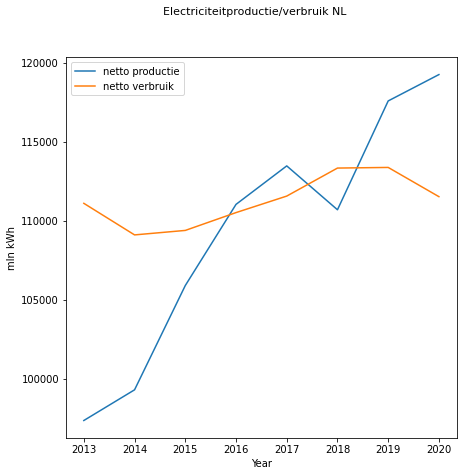

In [139]:
# Get values from the needed columns in a List to use them to plot.
x_axis = df2_electricity_production.rdd.map(lambda l:l.periode).collect()
y_axis1 = df2_electricity_production.rdd.map(lambda l:l.netto_productie).collect()
y_axis2 = df2_electricity_production.rdd.map(lambda l:l.netto_verbruik).collect()
figure_netto_production = plt.figure(figsize=(7, 7))
figure_netto_production.suptitle('Electriciteitproductie/verbruik NL', fontsize=11)
plt1 = figure_netto_production.add_subplot(111)
plt1.plot(x_axis, y_axis1, label = "netto productie")
plt1.plot(x_axis, y_axis2, label = "netto verbruik")
plt.xlabel("Year")
plt.ylabel("mln kWh")
plt.legend()
plt.show()

In [140]:
# Lets focus on renewable energy, show how much the share of renewable energy is of the whole netto production
labels = "Brandstoffen","Windenergie","Zonnestroom"
def show_renewable_energy_share(year):
    energy_distribution = df2_electricity_production.filter(df2_electricity_production.periode == year).collect()

    data = [energy_distribution[0].asDict()["netto_productie_brandstoffen"],energy_distribution[0].asDict()["netto_productie_windenergie"],energy_distribution[0].asDict()["netto_productie_zonnestroom"]]
 
    explode = (0, 0.1, 0.1)  # highlight the 2nd and 3rd slice of the pie chart
    fig1, ax1 = plt.subplots()
    plt.title('Energieproductie ' + str(year))
    ax1.pie(data, explode=explode, labels=labels, autopct='%1.1f%%',
    shadow=True, startangle=90)
    ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
    plt.show()

In [144]:
from IPython.display import HTML,display

form = """
<style>
    .ep-container {
        background-color: #f8f9fa; 
        width:300px; 
        padding:20px; 
        color: #495057;
    }
    .ep-button {
        padding:5px; 
        width: 100px; 
        border: none; 
        background-color: #ced4da; 
        color: #495057;
        transition: ease-in-out 0.1s;
    }
    .ep-button:hover {
        background-color: #adb5bd; 
        color: #343a40;
    }
    .ep-form-inputs-control {
        display: flex;
        flex-wrap: wrap;
        margin-top: 1em;
        margin-bottom: 2em;
    }
    .ep-input-wrapper {
        display: flex;
        margin-left: 1em;
        margin-right: 1em;
    }
</style>
<div class="ep-container">
<p> Select a year and press the Submit button to see how much the share of renewable energy is of the entire electricity production for that year:<p>
<div class="ep-form-inputs-control">
    <div class="ep-input-wrapper"><input type="radio" name="year" value="2015"><label>2015</label></div>
    <div class="ep-input-wrapper"><input type="radio" name="year" value="2016"><label>2016</label></div>
    <div class="ep-input-wrapper"><input type="radio" name="year" value="2017"><label>2017</label></div>
    <div class="ep-input-wrapper"><input type="radio" name="year" value="2018"><label>2018</label></div>
    <div class="ep-input-wrapper"><input type="radio" name="year" value="2019"><label>2019</label></div>
    <div class="ep-input-wrapper"><input type="radio" name="year" value="2020"><label>2020</label></div>
</div>
<button class="ep-button" type="button" onclick="set_vars()">Submit</button>
</div>
"""
javascript = """
<script type="text/Javascript">
    function set_vars(){
        var var_name1 = 'inp_year';
        var ele = document.getElementsByName('year');
        
        for(i = 0; i < ele.length; i++) {
                if(ele[i].checked)
                var var_value1 = ele[i].value;
            }
        var command1 = var_name1 + " = '" + var_value1 + "'";
        var kernel = IPython.notebook.kernel;
        kernel.execute(command1);
        cell = IPython.notebook.get_cell(40);
        cell.execute();
        cell.focus_cell(40);
    }
</script>
"""

HTML(form + javascript)

Year: 2019


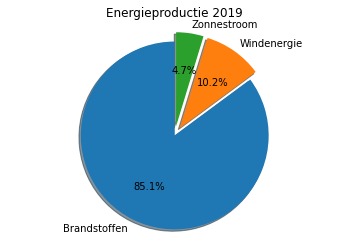

In [149]:
print("Year: " + inp_year)
show_renewable_energy_share(int(inp_year))

Als je de pie chart bekijkt van de verschillende jaren dan zie je dat er toch meer en meer ingezet wordt op hernieuwbare energie en dat de energieproductie door middel van het verbranden van brandstoffen ieder jaar afneemt. 

In [143]:

## Belangrijk!! vergeet cellnumber niet aan te passen bij de interactieve widget.
## Al geprobeerd met get_selected_cell() maar heb het nog niet werkend gekregen. 